In [1]:
import numpy as np
np.random.seed(0)
from numpy.matlib import repmat
import sys
import time
import visclassifier
import matplotlib
import matplotlib.pyplot as plt
import traceback

#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#misc imports
import random

from l2distance import l2distance


In [2]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # construct random w and b vectors
    gt_w = torch.randn(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.rand(num_samples, 1) * 0.2
    test_noise = np.random.rand(int(num_samples * 0.1), 1) * 0.2
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [3]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

In [5]:
def mse_loss(y_pred, y_true):
    square_diff = torch.square((y_pred-y_true))
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

In [6]:
def train_regression_model(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [7]:
model = train_regression_model(lr_xTr, lr_yTr, num_epochs=2000, reg_param=0.001, lr=1e-2)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.25935222755143866
epoch 200 loss 0.025217553112142323
epoch 300 loss 0.006631808452201684
epoch 400 loss 0.004869205736829943
epoch 500 loss 0.004455054920576547
epoch 600 loss 0.004179981902095066
epoch 700 loss 0.003945654636266172
epoch 800 loss 0.003740721040442275
epoch 900 loss 0.0035610720379003332
epoch 1000 loss 0.003403555101717175
epoch 1100 loss 0.0032654394265754423
epoch 1200 loss 0.0031443385943847294
epoch 1300 loss 0.0030381555778057345
epoch 1400 loss 0.0029450487832086633
epoch 1500 loss 0.002863411832740908
epoch 1600 loss 0.002791831615297368
epoch 1700 loss 0.002729068862896041
epoch 1800 loss 0.002674035916650311
epoch 1900 loss 0.0026257812922977986
epoch 2000 loss 0.0025834718366731083
avg test error 0.0019501591731751506


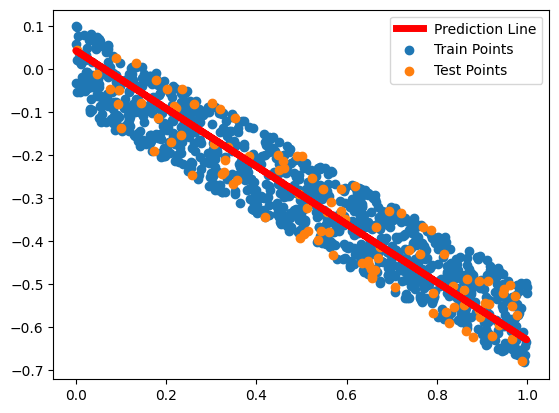

In [8]:
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

In [9]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

In [10]:
def hinge_loss(y_pred, y_true):
    return torch.sum(torch.max(torch.zeros(y_pred.shape[0]), torch.ones(y_pred.shape[0]) - y_pred * y_true))
    

In [11]:
class LinearClassifier(nn.Module):
    """Support Vector Machine"""

    def __init__(self, dim):
        super(LinearClassifier, self).__init__()
        self.w = nn.Parameter(torch.randn(dim, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, x):
        return (x @ self.w + self.b).squeeze()

In [12]:
def primalSVM(xTr, yTr, num_epochs=1000, C=1):
    svm = LinearClassifier(xTr.shape[-1])
    
    optimizer = optim.SGD(svm.parameters(), lr=1e-2)
    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = C * hinge_loss(yTr, svm.forward(xTr)) + torch.norm(svm.w, p=2) 
        loss.backward()
        optimizer.step()

    return lambda x: svm.forward(x) 


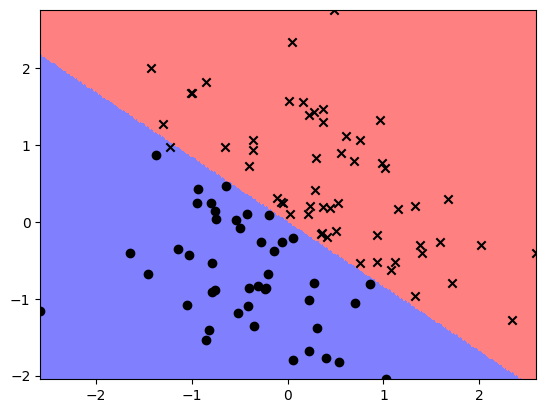

Training error: 1.0%


In [13]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [14]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
    
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

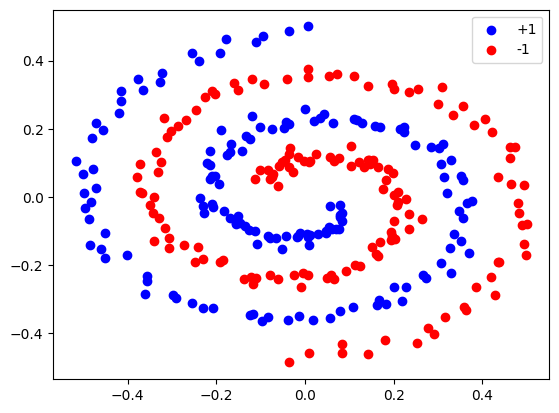

In [15]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

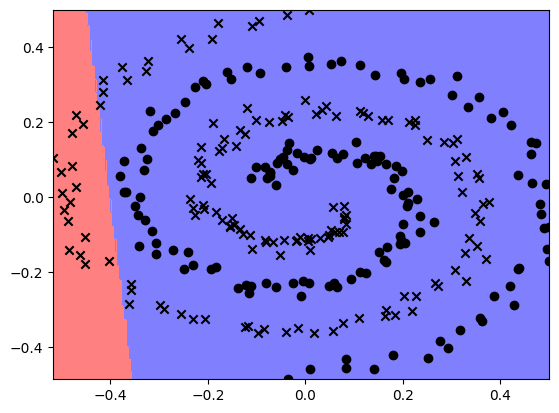

Training error: 44.7%


In [16]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [17]:
def computeK(kernel_type, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    def enforce_positive_definite(K, reg=1e-6):
        n = K.shape[0]
        if n == K.shape[1]:
            return K + reg * torch.eye(n, dtype=torch.float32)
        else:
            return K
    
    if kernel_type == 'linear': 
        return enforce_positive_definite(torch.matmul(X, Z.T))
    elif kernel_type == 'rbf': 
        return torch.exp(-kpar*l2distance(X, Z))
        # return torch.exp(-kpar*torch.pow(l2distance(X, Z), 2))
    else: 
        return enforce_positive_definite(torch.pow(torch.matmul(X, Z.T) + 1, kpar))


torch.float32


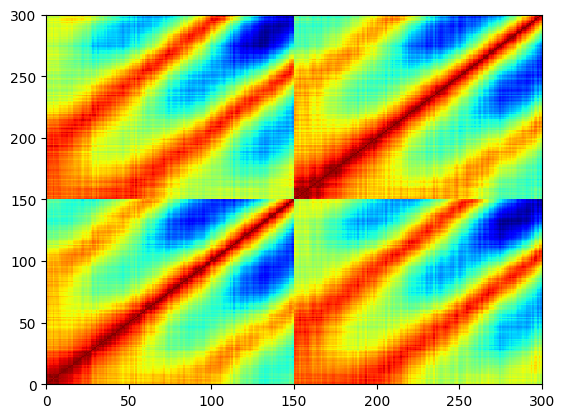

In [18]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
print(K.dtype)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

In [19]:
class KernelizedSVM(nn.Module):
    def __init__(self, n_samples, kernel_type, kpar=0.01):
        super(KernelizedSVM, self).__init__()
        self.kernel_type = kernel_type
        self.kpar = kpar
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
        self.beta = nn.Parameter(torch.randn(n_samples, ), requires_grad=True)
    
    def forward(self, xTr, x):
        K = computeK(self.kernel_type, xTr, x, self.kpar)        
        return K.T @ self.beta + self.b



In [20]:
def kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C):
    hinge_loss = (C / 2) * torch.sum( F.relu( 1 - yTr * ( kernel_mat @ kernelizedSVM.beta + kernelizedSVM.b ) ) ) 
    regularization_loss = 0.5 * kernelizedSVM.beta.T @ kernel_mat @ kernelizedSVM.beta

    return  hinge_loss + regularization_loss


In [21]:
def dualSVM(xTr, yTr, kernel_type, num_epochs=1000, C=10, lmbda=0, lr=1e-3):
    
    kernel_svm = KernelizedSVM(xTr.shape[0], kernel_type, kpar=lmbda)
    optimizer = optim.SGD(kernel_svm.parameters(), lr=lr)

    K = computeK(kernel_type, xTr, xTr, kpar=lmbda)  

    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = kernelsvm_loss(kernel_svm, K, yTr, C)
        loss.backward()
        optimizer.step()

    return lambda x: kernel_svm.forward(xTr, x)

In [22]:
def train_test_split(X, y):
    n = X.shape[0]
    train_idx = np.random.choice(n, int(n * 0.8), replace=False)
    test_idx = np.setdiff1d(np.arange(n), train_idx)
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [23]:
def generate_noisy_data(N=1000):
    mean1 = torch.tensor([0, 0], dtype=torch.float32)
    cov1 = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
    x1 = torch.distributions.multivariate_normal.MultivariateNormal(mean1, cov1).sample((N,))
    y1 = torch.ones((N,), dtype=torch.float32)

    mean2 = torch.tensor([1, 1], dtype=torch.float32)
    cov2 = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
    x2 = torch.distributions.multivariate_normal.MultivariateNormal(mean2, cov2).sample((N,))
    y2 = -torch.ones((N,), dtype=torch.float32)

    return torch.cat((x1, x2), dim=0), torch.cat((y1, y2), dim=0)


def generate_imbalanced_data(N=1000):
    n_features = 2
    labels = torch.distributions.Binomial(total_count=1, probs=0.1).sample((N,)).float()
    labels = 2 * labels - 1  # convert 0s to -1s and 1s to 1s
    return torch.randn((N, n_features)), labels

def generate_high_dim_data(N=1000):
    n_features = 100
    return torch.randn((N, n_features)), torch.tensor(torch.distributions.Bernoulli(torch.tensor(0.5)).sample((N,)), dtype=torch.float32)

def generate_spiral_data(N=1000):
    r = torch.linspace(1, 2 * np.pi, N)
    X1 = torch.stack([torch.sin(2. * r) * r, torch.cos(2 * r) * r], dim=1)
    X2 = torch.stack([torch.sin(2. * r + np.pi) * r, torch.cos(2 * r + np.pi) * r], dim=1)
    X_final = torch.cat([X1, X2], dim=0)
    y = torch.cat([torch.ones(N, dtype=torch.float32), -torch.ones(N, dtype=torch.float32)])
    X_final = X_final + torch.randn(X_final.shape) * 0.2
    
    return X_final, y

def generate_block_data(N=1000, x1_min=-10, x1_max=10, x2_min=0, x2_max=5, B=6):
    x1_range = x1_max - x1_min
    h = x1_range / B

    X = torch.zeros((N, 2))
    y = torch.ones(N)

    X[:, 1] = torch.distributions.Uniform(torch.tensor(x2_min, dtype=torch.float32), 
                                            torch.tensor(x2_max, dtype=torch.float32)).sample((N,))
    
    X[:,0] = torch.linspace(x1_min, x1_max, N)
    x1_intervals = torch.linspace(x1_min, x1_max, B+1)
    
    for i in range(B):
        mask = ((X[:, 0] >= x1_intervals[i]) & (X[:, 0] < x1_intervals[i+1]))
        y[mask] = -1 if i % 2 == 1 else 1

        X_block = X[mask, :]
        X_block[:, 0] = x1_intervals[i] + torch.rand((X_block.shape[0],)) * h
        X[mask, :] = X_block

    return X, y




/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_2047/2552487430.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  regularization_loss = 0.5 * kernelizedSVM.beta.T @ kernel_mat @ kernelizedSVM.beta
/Users/eirikbaekkelund/opt/anaconda3/envs/applied-ml/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/eirikbaekkelund/opt/anaconda3/envs/applied-ml/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


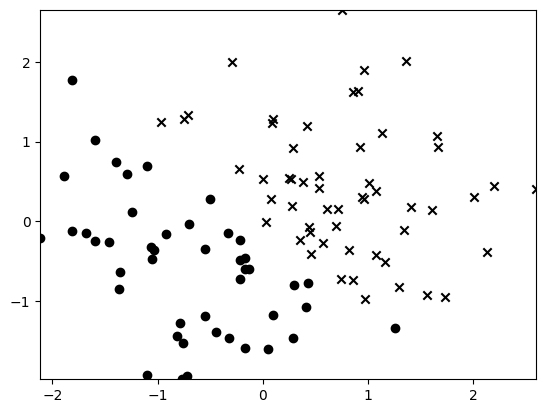

Training error: 1.0000
Testing error: 1.0000


In [24]:
xTr,yTr,xTe,yTe=spiraldata()
xTr, yTr= genrandomdata(100)

# poly kernel parameters that don't blow up vvv
ktype="poly"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=10, lmbda=100, lr=1e-4)
visclassifier.visclassifier(svmclassify,xTr,yTr)

# linear kernel parameters that also don't blow up vvv
# ktype="linear"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1, lmbda=0.05, lr=1e-4)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# rbf kernel with parameters that achieve perfect accuracy vvv 
# ktype="rbf"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=10, lmbda=100, lr=1e-3)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error

predsTr=svmclassify(xTr)
trainingerr=torch.mean((torch.sign(predsTr)!=yTr).float())
print("Training error: %2.4f" % trainingerr)
print("Testing error: %2.4f" % torch.mean((torch.sign(svmclassify(xTe))!=yTe).float()))


In [25]:
def lower_bound_lmbad_rbf(xTr, min_exp=0.1):
    """ 
    min_exp=0.01
    Computes the lower bound on lambda for the RBF kernel.
    
    Paramters:
    ----------
    xTr: torch.Tensor
    min_exp: float (default: 0.1)

    Returns:
    --------
    lmbda_lower_bound: torch.Tensor
    """
    distances = l2distance(xTr, xTr)
    d_max = np.max(distances.numpy())
    lmbda_lower_bound = -np.log(min_exp) / d_max
    
    return lmbda_lower_bound

In [26]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList,lr_List):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
        lr_list  | The list of values to try for the learning rate of our optimizer
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        bestLr     | the best Lr parameter
        ErrorMatrix| the test error rate for each given (C, Lmbda Lr) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """
    # YOUR CODE HERE
    lmbda_lower_bound = lower_bound_lmbad_rbf(xTr)
    if ktype == 'rbf' and lmbdaList[0] < lmbda_lower_bound:
        lmbdaList = lmbdaList + lmbda_lower_bound
    

    error_matrix = torch.zeros(len(CList), len(lmbdaList), len(lr_List))
    best_idx_c, best_idx_lmbda, best_idx_lr = 0, 0, 0
    best_loss = np.inf
    
    for idx_C, C in enumerate(CList):
        for idx_lmbda, lmbda in enumerate(lmbdaList):
            for idx_lr, lr in enumerate(lr_List):
                svmclassify = dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=100, C=C, lmbda=lmbda, lr=lr)
                preds = svmclassify(xValid)
                loss = torch.mean((torch.sign(preds)!=yValid).float())
                error_matrix[idx_C, idx_lmbda, idx_lr] = loss
                if loss < best_loss:
                    best_loss = loss
                    best_idx_c, best_idx_lmbda, best_idx_lr = idx_C, idx_lmbda, idx_lr

    bestC = CList[best_idx_c]
    bestLmbda = lmbdaList[best_idx_lmbda]
    bestLr = lr_List[best_idx_lr]

    return bestC, bestLmbda, bestLr, error_matrix

In [27]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,10,10))
lmbdaList=(np.linspace(0.1,10,10))
lrList=(np.linspace(0.001,0.1,5))

bestC,bestLmbda,bestLr,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,
                                                      'rbf',CList,lmbdaList,
                                                      lrList)

In [33]:
torch.linspace(0,10,10)

tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
         8.8889, 10.0000])

In [40]:
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    x_train, x_test, y_train, y_test = train_test_split(xTr, yTr)
    lmbda_lower_bound = lower_bound_lmbad_rbf(x_train)
    CList=(2.0**np.linspace(-1,10,10))
    lmbdaList=(np.linspace(lmbda_lower_bound,lmbda_lower_bound + 200,10))
    lrList=(np.linspace(0.001,0.1,5))
    bestC, bestLmbda, bestLr,  _ = cross_validation(x_train,y_train,x_test,y_test,'rbf', CList, lmbdaList, lrList)

    print(f"bestC = {round(bestC,3)}, bestLmbda = {round(bestLmbda,4)}, bestLr = {round(bestLr,3)}")
    
    return dualSVM(xTr, yTr, kernel_type='rbf', num_epochs=1000, C=bestC, lmbda=bestLmbda, lr=bestLr)

bestC = 6.35, bestLmbda = 0.7147, bestLr = 0.001


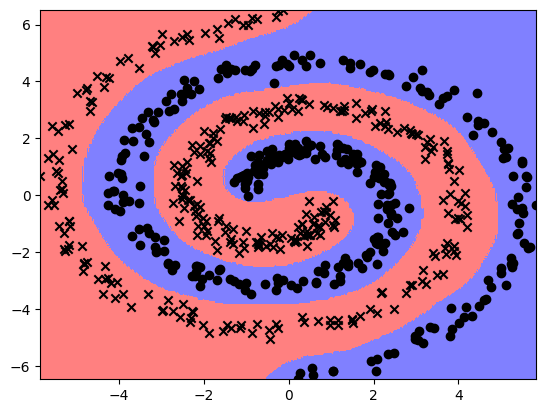

Training error: 0.0000
Testing error: 0.0000
bestC = 0.5, bestLmbda = 1.5386, bestLr = 0.001


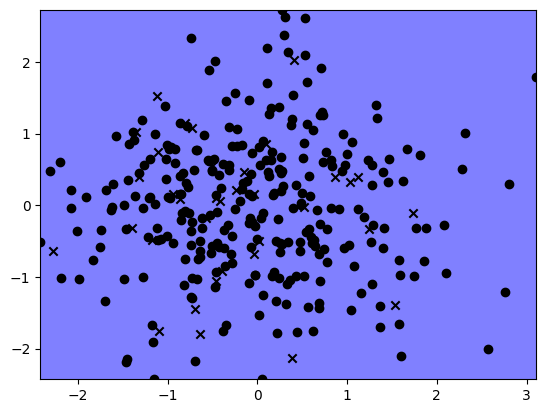

Training error: 0.1094
Testing error: 0.1500
bestC = 14.814, bestLmbda = 1.4642, bestLr = 0.001


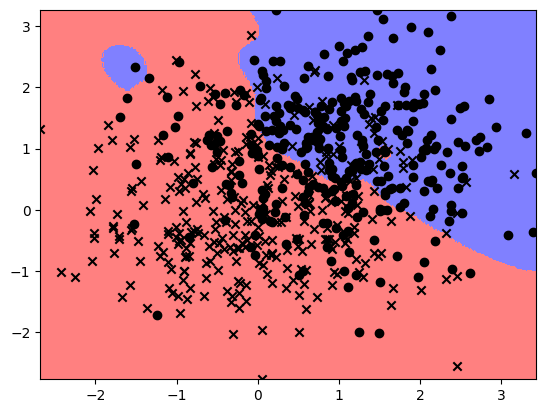

Training error: 0.2484
Testing error: 0.2875
bestC = 80.635, bestLmbda = 0.4588, bestLr = 0.001


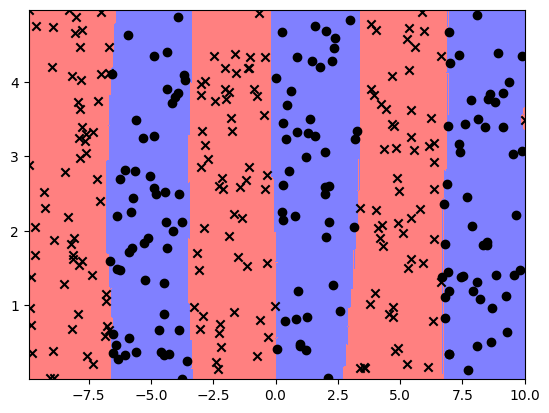

Training error: 0.0000
Testing error: 0.0250


In [41]:
for data_func in [generate_spiral_data, generate_imbalanced_data, generate_noisy_data, generate_block_data]:
    X, y = data_func(400)
    x_train, x_test, y_train, y_test = train_test_split(X, y)
    svmclassify=autosvm(x_train,y_train)
    visclassifier.visclassifier(svmclassify,x_train,y_train)
    predsTr=svmclassify(x_train)
    trainingerr=torch.mean((torch.sign(predsTr)!=y_train).float())
    print("Training error: %2.4f" % trainingerr)
    predsTe=svmclassify(x_test)
    testingerr=torch.mean((torch.sign(predsTe)!=y_test).float())
    print("Testing error: %2.4f" % testingerr)